# Sentiment analysis of collected tweets

---



# Importing libraries

In [101]:
!pip install unidecode

In [102]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate, KFold, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC, SVC
from string import punctuation
from wordcloud import WordCloud
from nltk import tokenize


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import unidecode
import nltk

In [103]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

# Loading data

## Loading the datasets

In [104]:
df_tweets = pd.read_csv("/content/drive/MyDrive/DI - Analise Bitcoin - GPU/4. Execução/1. Organização dos Dados Coletados/0. Dados Organizados/Tweets.csv")
df_bitcoin = pd.read_csv("/content/drive/MyDrive/DI - Analise Bitcoin - GPU/4. Execução/1. Organização dos Dados Coletados/0. Dados Organizados/BTC-organized.csv")

Adjusting the data types from tweets dataframe

In [105]:
df_tweets['Tweet'] = df_tweets['Tweet'].astype(str)
df_tweets['User'] = df_tweets['User'].astype(str)
df_tweets['Date'] = df_tweets['Date'].astype('datetime64[ns]')
df_tweets = df_tweets[['Tweet', 'User', 'Date']]
df_tweets

,Tweet,User,Date
0,"Do you think #bitcoin will reach $500K, $288K ...",@100trillionUSD,2021-10-03
1,"Do you think #bitcoin will reach $500K, $288K ...",@100trillionUSD,2021-09-11
2,43k,@100trillionUSD,2021-09-07
3,"Do you think #bitcoin will reach $500K, $288K ...",@100trillionUSD,2021-08-15
4,So was $64K the top for this cycle (halving 20...,@100trillionUSD,2021-07-01
...,...,...,...
64940,And it's started... #tedxtearo nice work guys!,@woonomic,2012-11-30
64941,On knowledge: Circa 1400 a book cost you the p...,@woonomic,2011-03-07
64942,"Opened up my new MacBook Pro 13 Unibody. Wow, ...",@woonomic,2009-10-09
64943,GMail Tip: just discovered you can drag label...,@woonomic,2009-07-29


Auxiliary tweets dataset

In [106]:
df_only_tweets = df_tweets[['Tweet', 'Date']]

Adjusting the data type from from 

In [107]:
df_bitcoin['Date'] = df_bitcoin['Date'].astype('datetime64[ns]')
df_bitcoin

,Date,Open,Close,Balance,Rise
0,2021-10-18,61548.804688,62026.078125,477.273437,1.0
1,2021-10-17,60887.652344,61553.617188,665.964844,1.0
2,2021-10-16,61609.527344,60892.179688,-717.347656,0.0
3,2021-10-15,57345.902344,61593.949219,4248.046875,1.0
4,2021-10-14,57372.832031,57321.523438,-51.308593,0.0
...,...,...,...,...,...
2584,2014-09-21,408.084991,398.821014,-9.263977,0.0
2585,2014-09-20,394.673004,408.903992,14.230988,1.0
2586,2014-09-19,424.102997,394.795990,-29.307007,0.0
2587,2014-09-18,456.859985,424.440002,-32.419983,0.0


## Organizing bitcoin and tweets datasets

### Tweets

In [108]:
df_only_tweets

,Tweet,Date
0,"Do you think #bitcoin will reach $500K, $288K ...",2021-10-03
1,"Do you think #bitcoin will reach $500K, $288K ...",2021-09-11
2,43k,2021-09-07
3,"Do you think #bitcoin will reach $500K, $288K ...",2021-08-15
4,So was $64K the top for this cycle (halving 20...,2021-07-01
...,...,...
64940,And it's started... #tedxtearo nice work guys!,2012-11-30
64941,On knowledge: Circa 1400 a book cost you the p...,2011-03-07
64942,"Opened up my new MacBook Pro 13 Unibody. Wow, ...",2009-10-09
64943,GMail Tip: just discovered you can drag label...,2009-07-29


Agroup the dataset lines by date

Adjusting the order by the most recent date

In [109]:
df_bitcoin

,Date,Open,Close,Balance,Rise
0,2021-10-18,61548.804688,62026.078125,477.273437,1.0
1,2021-10-17,60887.652344,61553.617188,665.964844,1.0
2,2021-10-16,61609.527344,60892.179688,-717.347656,0.0
3,2021-10-15,57345.902344,61593.949219,4248.046875,1.0
4,2021-10-14,57372.832031,57321.523438,-51.308593,0.0
...,...,...,...,...,...
2584,2014-09-21,408.084991,398.821014,-9.263977,0.0
2585,2014-09-20,394.673004,408.903992,14.230988,1.0
2586,2014-09-19,424.102997,394.795990,-29.307007,0.0
2587,2014-09-18,456.859985,424.440002,-32.419983,0.0


In [110]:
bitcoin_dates = df_bitcoin['Date'].to_list()
tweets_dates =  df_only_tweets['Date'].to_list()

Removing the dates from tweet dataset that aren't in bitcoin dataset

In [111]:
x = 0
for date_tweet in tweets_dates:
  if date_tweet not in bitcoin_dates:
    df_only_tweets.drop(index=x, axis=0, inplace=True)
  x += 1

    

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [112]:
df_only_tweets.sort_values(by='Date', ascending=False, ignore_index=True, inplace=True)
df_only_tweets

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Tweet,Date
0,Reasons why I'm bullish on #Bitcoin:\n\n About...,2021-10-18
1,First U.S. #bitcoin ETF looks set to debut Tue...,2021-10-18
2,Top10 Twitter KOL & Gem Rating Oct.18\n1 $DOGE...,2021-10-18
3,"#bitcoin over $62,000 again. \n\n$3,000 to go.",2021-10-18
4,Shiba Inu could Reach 50 Cents By December 202...,2021-10-18
...,...,...
63313,"""\n@IconicExpert\n: @nomaxpi \n@CryptoCobain\n...",2014-09-17
63314,Can someone send me their btc address? Theblon...,2014-09-17
63315,"""\n@moolah_io\n: @GambitBTC $VIA is on the fin...",2014-09-17
63316,What if we all take out loans + buy bitcoin. D...,2014-09-17


### Bitcoin

Removing the dates from bitcoin dataset that aren't in tweet dataset

In [113]:
bitcoin_dates = df_bitcoin['Date'].to_list()
tweets_dates =  df_only_tweets['Date'].to_list()

In [114]:
x = 0
for data_bitcoin in bitcoin_dates:
  if data_bitcoin not in tweets_dates:
    df_bitcoin.drop(index=x, axis=0, inplace=True)
  x += 1

    

In [115]:
df_bitcoin.sort_values(by='Date', ascending=False, ignore_index=True, inplace=True)
df_bitcoin

,Date,Open,Close,Balance,Rise
0,2021-10-18,61548.804688,62026.078125,477.273437,1.0
1,2021-10-17,60887.652344,61553.617188,665.964844,1.0
2,2021-10-16,61609.527344,60892.179688,-717.347656,0.0
3,2021-10-15,57345.902344,61593.949219,4248.046875,1.0
4,2021-10-14,57372.832031,57321.523438,-51.308593,0.0
...,...,...,...,...,...
2560,2014-09-21,408.084991,398.821014,-9.263977,0.0
2561,2014-09-20,394.673004,408.903992,14.230988,1.0
2562,2014-09-19,424.102997,394.795990,-29.307007,0.0
2563,2014-09-18,456.859985,424.440002,-32.419983,0.0


Join the datasets

## Join the bicoin and tweets datasets

Transform date columns in lists

In [116]:
bitcoin_dates = df_bitcoin['Date'].to_list()
tweets_dates =  df_only_tweets['Date'].to_list()
rise_list = df_bitcoin['Rise'].to_list()

Removing the dates from bitcoin dataset that aren't in tweet dataset

In [117]:
new_cotation = list()

for date_tweet in tweets_dates: # Go in each one of the element in tweets_dates list
  for date_bitcoin in bitcoin_dates: # Go in each one of the element in bitcoin_dates list
    if date_tweet == date_bitcoin: # Check if there is a element in bitcoin dates that are equal to the date_tweet 
      index_bitcoin_date = bitcoin_dates.index(date_tweet) # if exists find it index in the list
      new_cotation.append(rise_list[index_bitcoin_date]) # add the rise or down of the day in the new_cotation list

    

In [118]:
len(new_cotation) == len(df_only_tweets['Tweet'])

True

In [119]:
new_cotation =  pd.Series(new_cotation)
new_cotation

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
63313    0.0
63314    0.0
63315    0.0
63316    0.0
63317    0.0
Length: 63318, dtype: float64

In [120]:
df_only_tweets

,Tweet,Date
0,Reasons why I'm bullish on #Bitcoin:\n\n About...,2021-10-18
1,First U.S. #bitcoin ETF looks set to debut Tue...,2021-10-18
2,Top10 Twitter KOL & Gem Rating Oct.18\n1 $DOGE...,2021-10-18
3,"#bitcoin over $62,000 again. \n\n$3,000 to go.",2021-10-18
4,Shiba Inu could Reach 50 Cents By December 202...,2021-10-18
...,...,...
63313,"""\n@IconicExpert\n: @nomaxpi \n@CryptoCobain\n...",2014-09-17
63314,Can someone send me their btc address? Theblon...,2014-09-17
63315,"""\n@moolah_io\n: @GambitBTC $VIA is on the fin...",2014-09-17
63316,What if we all take out loans + buy bitcoin. D...,2014-09-17


In [121]:
df_tweets_increase = df_only_tweets
df_tweets_increase['Raise'] = new_cotation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [122]:
df_tweets_increase

,Tweet,Date,Raise
0,Reasons why I'm bullish on #Bitcoin:\n\n About...,2021-10-18,1.0
1,First U.S. #bitcoin ETF looks set to debut Tue...,2021-10-18,1.0
2,Top10 Twitter KOL & Gem Rating Oct.18\n1 $DOGE...,2021-10-18,1.0
3,"#bitcoin over $62,000 again. \n\n$3,000 to go.",2021-10-18,1.0
4,Shiba Inu could Reach 50 Cents By December 202...,2021-10-18,1.0
...,...,...,...
63313,"""\n@IconicExpert\n: @nomaxpi \n@CryptoCobain\n...",2014-09-17,0.0
63314,Can someone send me their btc address? Theblon...,2014-09-17,0.0
63315,"""\n@moolah_io\n: @GambitBTC $VIA is on the fin...",2014-09-17,0.0
63316,What if we all take out loans + buy bitcoin. D...,2014-09-17,0.0


In [123]:
df_tweets_increase['Raise'] = df_tweets_increase['Raise'].astype(int)
df_tweets_increase

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Tweet,Date,Raise
0,Reasons why I'm bullish on #Bitcoin:\n\n About...,2021-10-18,1
1,First U.S. #bitcoin ETF looks set to debut Tue...,2021-10-18,1
2,Top10 Twitter KOL & Gem Rating Oct.18\n1 $DOGE...,2021-10-18,1
3,"#bitcoin over $62,000 again. \n\n$3,000 to go.",2021-10-18,1
4,Shiba Inu could Reach 50 Cents By December 202...,2021-10-18,1
...,...,...,...
63313,"""\n@IconicExpert\n: @nomaxpi \n@CryptoCobain\n...",2014-09-17,0
63314,Can someone send me their btc address? Theblon...,2014-09-17,0
63315,"""\n@moolah_io\n: @GambitBTC $VIA is on the fin...",2014-09-17,0
63316,What if we all take out loans + buy bitcoin. D...,2014-09-17,0


# Vectorizing the raw data

In [124]:
df_tweets_increase

,Tweet,Date,Raise
0,Reasons why I'm bullish on #Bitcoin:\n\n About...,2021-10-18,1
1,First U.S. #bitcoin ETF looks set to debut Tue...,2021-10-18,1
2,Top10 Twitter KOL & Gem Rating Oct.18\n1 $DOGE...,2021-10-18,1
3,"#bitcoin over $62,000 again. \n\n$3,000 to go.",2021-10-18,1
4,Shiba Inu could Reach 50 Cents By December 202...,2021-10-18,1
...,...,...,...
63313,"""\n@IconicExpert\n: @nomaxpi \n@CryptoCobain\n...",2014-09-17,0
63314,Can someone send me their btc address? Theblon...,2014-09-17,0
63315,"""\n@moolah_io\n: @GambitBTC $VIA is on the fin...",2014-09-17,0
63316,What if we all take out loans + buy bitcoin. D...,2014-09-17,0


### Vectorizing

In [125]:
vectorizer = CountVectorizer(lowercase=False)

In [126]:
bag_of_words_raw_data = vectorizer.fit_transform(df_tweets_increase['Tweet'])

In [127]:
bag_of_words_raw_data.shape

(63318, 51668)

### Function to help print the values

In [128]:
def print_accuracy(model_name, acry_score):
  print("The accuracy score of the model ->{}<-".format(model_name) + " is {:.3f}".format((acry_score*100)) + "%")

### Creating a LogisticRegression
The accuracy score of the model ->Logistic Regression<- is 57.265%

train_test_split

In [129]:
x = bag_of_words_raw_data
y = df_tweets_increase['Raise']

In [130]:
x_train, x_test, y_train_label, y_test_label = train_test_split(
    x,
    y,
    random_state = 42,  
    test_size = 0.10, 
    stratify = y
)

Train

In [131]:
logistic_regression = LogisticRegression(solver='lbfgs')
logistic_regression.fit(x_train, y_train_label)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Test

In [132]:
test_prevision = logistic_regression.predict_proba(x_test)
print(test_prevision)
# print_accuracy('Logistic Regressinon', test_prevision)

[[0.53510307 0.46489693]
 [0.52191203 0.47808797]
 [0.63053579 0.36946421]
 ...
 [0.25366702 0.74633298]
 [0.3446203  0.6553797 ]
 [0.30359844 0.69640156]]


In [133]:
test_prevision_bol = test_prevision[:,1] >= 0.5
print(test_prevision_bol)

[False False False ...  True  True  True]


In [134]:
test_prevision_int = test_prevision_bol.astype(np.int)
print(test_prevision_int)

[0 0 0 ... 1 1 1]


In [135]:
x_test.size

106966

In [136]:
test_prevision_int.size

6332

Printing the Accuracy Score

In [137]:
lr_acy_scr = accuracy_score(y_test_label, test_prevision_int)  
print_accuracy("Logistic Regression", lr_acy_scr)

The accuracy score of the model ->Logistic Regression<- is 57.265%


### Dummy 
The accuracy score of the model ->Dummy<- is 49.826%

In [138]:
dummy_stratified = DummyClassifier()
dummy_stratified.fit(x_train, y_train_label)
acy = dummy_stratified.score(test_prevision_int, y_test_label)

/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [139]:
print_accuracy('Dummy', acy)

The accuracy score of the model ->Dummy<- is 49.842%


### LinearSVC
The accuracy score of the model ->Logistic LinearSVC<- is 57.144%

In [140]:
x = bag_of_words_raw_data
y = df_tweets_increase['Raise']

In [141]:
SEED = 5

np.random.seed(SEED)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = SEED, test_size = 0.25, stratify=y) 
model = LinearSVC()
model.fit(x_train, y_train)
predictions = model.predict(x_test)

acy_sre = accuracy_score(y_test, predictions)
print(f"The accuracy score of this model is: {(acy_sre)*100}")

The accuracy score of this model is: 57.14466203411245


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Analyze of tweets column with a Word Cloud and Pareto

## Word Cloud raw data

A list of all phrase

In [142]:
all_phrase = [tweet for tweet in df_tweets_increase['Tweet']]

Agglutinating the phrase

In [143]:
agg_phrase = ' '.join(all_phrase)

Creating the Word Cloud

In [144]:
tw_wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,
                          collocations = False).generate(agg_phrase)

Plotting the word cloud


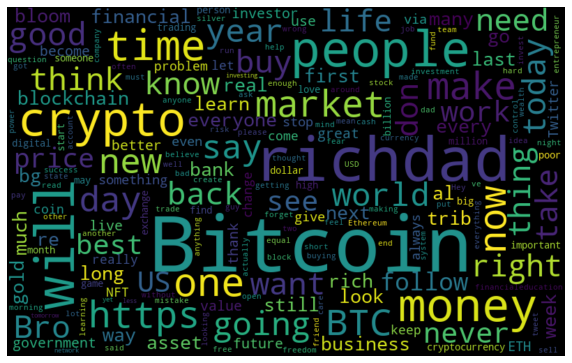

In [145]:
plt.figure(figsize=(10, 7))
plt.imshow(tw_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Postive day

In [146]:
query_postive = df_tweets_increase['Raise'] == 1
df_postive_days = df_tweets_increase[query_postive]

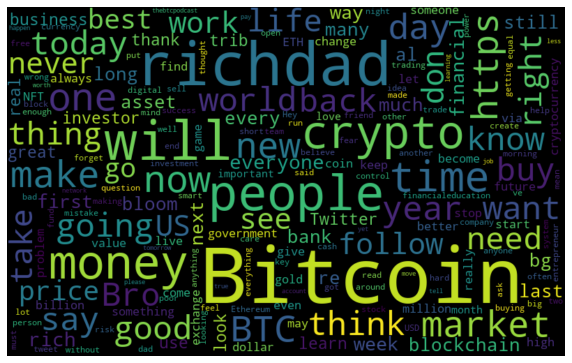

In [147]:
all_phrase = [tweet for tweet in df_postive_days['Tweet']]
agg_phrase = ' '.join(all_phrase)
tw_wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,
                          collocations = False).generate(agg_phrase)
plt.figure(figsize=(10, 7))
plt.imshow(tw_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Negative day

In [148]:
query_negative = df_tweets_increase['Raise'] == 0
df_negative_days = df_tweets_increase[query_postive]

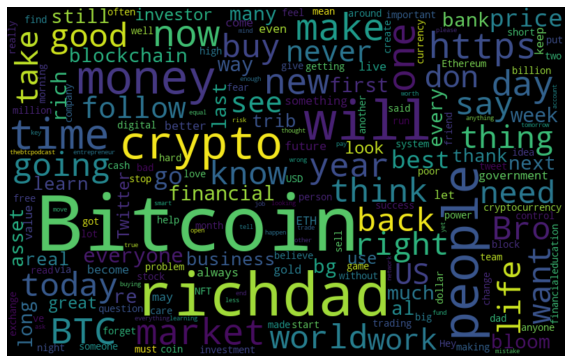

In [149]:
all_phrase = [tweet for tweet in df_negative_days['Tweet']]
agg_phrase = ' '.join(all_phrase)
tw_wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,
                          collocations = False).generate(agg_phrase)
plt.figure(figsize=(10, 7))
plt.imshow(tw_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Tokenization to create a new view

In [150]:
all_phases = [tweet for tweet in df_tweets_increase['Tweet']]
agg_phases = ' '.join(all_phases)

Tokenization with white spaces

In [151]:
tokenizer_white_spaces = tokenize.WhitespaceTokenizer()
tokenized_phases = tokenizer_white_spaces.tokenize(agg_phases)
frequency = nltk.FreqDist(tokenized_phases)

## Creating a DataFrame to analyse the frequency

In [152]:
df_tw_words_frequency = pd.DataFrame(
    {
        'Words': list(frequency.keys()),
        'Frequency': list(frequency.values())
    }
)


In [153]:
df_tw_words_frequency.head()

,Words,Frequency
0,Reasons,5
1,why,845
2,I'm,1314
3,bullish,261
4,on,8708


In [154]:
top_10_frequent_words = df_tw_words_frequency.nlargest(columns='Frequency', n=10)
top_10_frequent_words

,Words,Frequency
87,the,40077
7,to,33542
119,a,24174
168,is,22111
121,of,20548
109,and,20114
93,you,16292
144,in,14721
277,for,11717
112,I,10974


View of the top 10 most frequent words

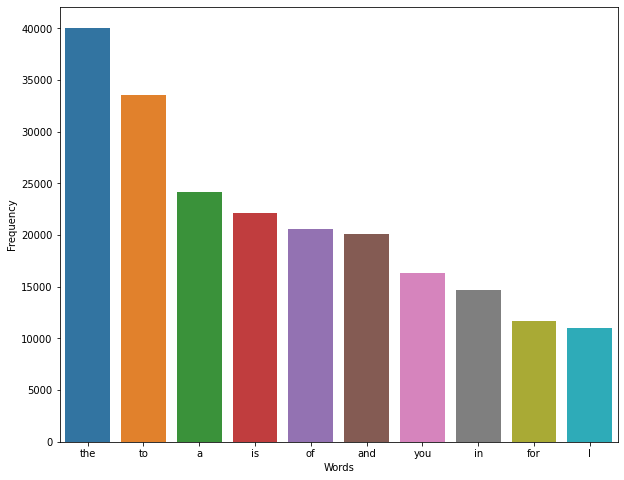

In [155]:
plt.figure(figsize=(10,8))
sns.barplot(data=top_10_frequent_words, x='Words', y='Frequency')
plt.show()

This words doesn't add up to our analysis, will be necessary to clean some of this words before start the sentiment analysis

# Tweets column optimization pipeline

## Functions to help the visualization and the classification

Functioin to plot a word cloud

In [156]:
def word_cloud_tweets(text, column_text):
  all_phrase = [tweet for tweet in text[column_text]]
  agg_phrase = ' '.join(all_phrase)
  tw_wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,
                          collocations = False).generate(agg_phases)
  plt.figure(figsize=(10, 7))

  plt.imshow(tw_wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()


Function to plot of the top 10 most frequent words

In [157]:
def top_most_frequent(text, column_text, length, title):
  all_phases = [tweet for tweet in text[column_text]]
  agg_phases = ' '.join(all_phases)
  tokenizer_white_spaces = tokenize.WhitespaceTokenizer()
  tokenized_phases = tokenizer_white_spaces.tokenize(agg_phases)
  frequency = nltk.FreqDist(tokenized_phases)
  df_tw_words_frequency = pd.DataFrame(
      {
          'Words': list(frequency.keys()),
          'Frequency': list(frequency.values())
      }
  )
  top_10_frequent_words = df_tw_words_frequency.nlargest(columns='Frequency', n=length)

  plt.figure(figsize=(10,8))
  plt.title(title)
  sns.barplot(data=top_10_frequent_words, x='Words', y='Frequency')
  plt.show()

Function to classify the days

In [158]:
def classify_texts_bag_of_words_log_reg(dataset, text_column, label_column, model_name):
  # Bag of words vectorizer
  bw_vectorizer = CountVectorizer(lowercase=False, max_features=50)
  bag_of_words = bw_vectorizer.fit_transform(dataset[text_column])

  # Model
  x = bag_of_words
  y = dataset[label_column]

  x_train, x_test, y_train_label, y_test_label = train_test_split(
      x,
      y,
      random_state = 42,  
      test_size = 0.10, 
      stratify = y
  )
  # Logistical Regression - Training

  logistic_regression = LogisticRegression(solver='lbfgs')
  logistic_regression.fit(x_train, y_train_label) 

  test_prevision = logistic_regression.predict_proba(x_test)

  test_prevision_bol = test_prevision[:,1] >= 0.5
  test_prevision_int = test_prevision_bol.astype(np.int)

  # Logistical Regression - Accuracy Score
  lr_acy_scr = accuracy_score(y_test_label, test_prevision_int)  

  return lr_acy_scr, print_accuracy(model_name, lr_acy_scr)

## Data processing 1

The accuracy score of the model ->DP1 - LogReg<- is 53.948%

To remove some of this words, will be used the stopwords from nltk library

In [159]:
initial_stopwords = nltk.corpus.stopwords.words("english")

In [160]:
processed_phrase = list()

for tweet in df_tweets_increase['Tweet']:
  new_phrase = list()
  tweet = tweet.lower()
  words_txt = tokenizer_white_spaces.tokenize(tweet)
  for word in words_txt:
    if word not in initial_stopwords:
      new_phrase.append(word)
  processed_phrase.append(' '.join(new_phrase))
df_tweets_increase['Data_processing_1'] = processed_phrase

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


### Word Cloud View

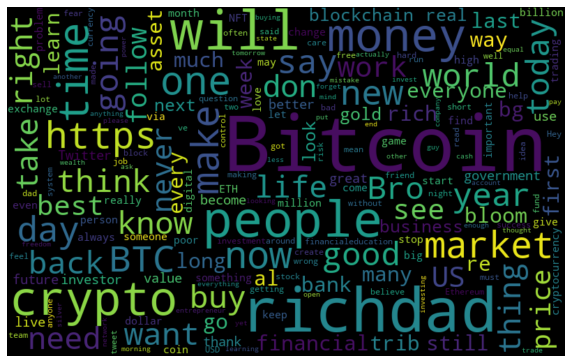

In [161]:
word_cloud_tweets(df_tweets_increase, 'Data_processing_1')

### Top 10

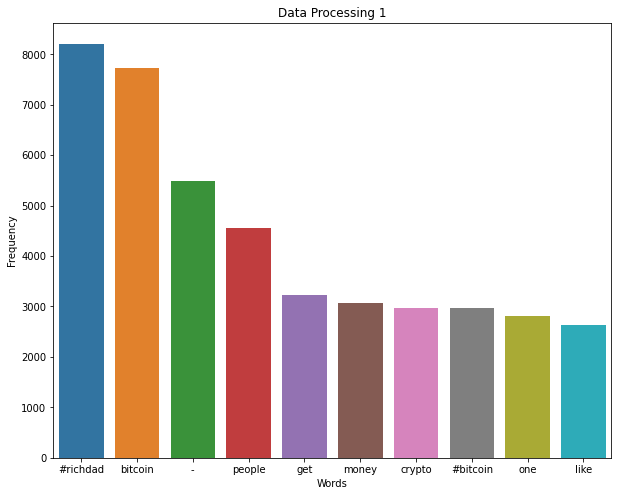

In [162]:
top_most_frequent(df_tweets_increase, 'Data_processing_1', 10, 'Data Processing 1')

### Classification

In [163]:
classify_texts_bag_of_words_log_reg(df_tweets_increase, 'Data_processing_1', 'Raise', 'DP1 - LogReg' )

The accuracy score of the model ->DP1 - LogReg<- is 53.948%


(0.5394819962097284, None)

## Data processing 2
The accuracy score of the model ->DP1 - LogReg<- is 54.027%

In [164]:
all_phases = [tweet for tweet in df_tweets_increase['Tweet']]
agg_phases = ' '.join(all_phases)

Optimizing the tokenization

In [165]:
tokenizer_punctuation = tokenize.WordPunctTokenizer()
tokenized_phases = tokenizer_punctuation.tokenize(agg_phases)

New stopwords with the punctuations

In [166]:
punctuation_sw = [element for element in punctuation]

In [167]:
stopwords_and_punctuation = initial_stopwords + punctuation_sw
stopwords_and_punctuation.append('://')

Removing the profile names citations on their tweets

In [168]:
profiles = pd.read_csv("/content/drive/MyDrive/DI - Analise Bitcoin - GPU/4. Execução/ Jupyter antigos/01 | Coleta de dados/01 | Twitter/perfis_twitter.csv")
profile_list = profiles['Perfis Twitter'].to_list()
stop_words_profiles_and_punctuation = profile_list + punctuation_sw

In [169]:
processed_phrase = list()

for tweet in df_tweets_increase['Data_processing_1']:
  new_phrase = list()
  words_txt = tokenizer_punctuation.tokenize(tweet)
  for word in words_txt:
    if word not in stop_words_profiles_and_punctuation:
      new_phrase.append(word)
  processed_phrase.append(' '.join(new_phrase))
df_tweets_increase['Data_processing_2'] = processed_phrase

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


### Word Cloud 

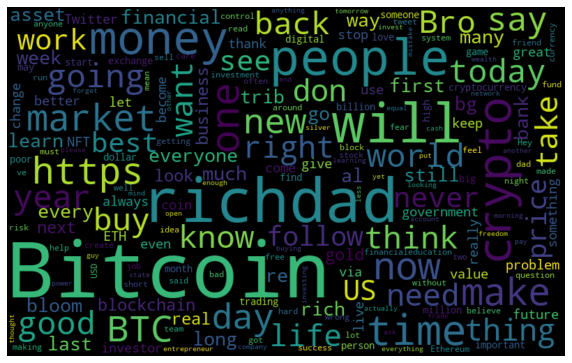

In [170]:
word_cloud_tweets(df_tweets_increase, 'Data_processing_2')

### Top10

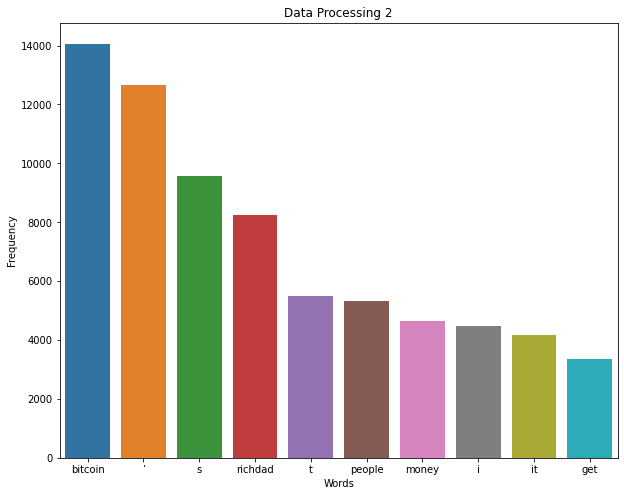

In [171]:
top_most_frequent(df_tweets_increase, 'Data_processing_2', 10, 'Data Processing 2')

### Classification

In [172]:
classify_texts_bag_of_words_log_reg(df_tweets_increase, 'Data_processing_2', 'Raise', 'DP1 - LogReg' )

The accuracy score of the model ->DP1 - LogReg<- is 54.027%


(0.5402716361339229, None)

## Data processing 3
The accuracy score of the model ->DP3 - LogReg<- is 54.090%

In [173]:
stopwords_no_unicode =  [unidecode.unidecode(text) for text in stopwords_and_punctuation]

Removing unicode elementes from the corpus

In [174]:
processed_phrase = list()

for tweet in df_tweets_increase['Data_processing_2']:
  new_phrase = list()
  words_txt = tokenizer_punctuation.tokenize(tweet)
  for word in words_txt:
    if word not in stopwords_no_unicode:
      new_phrase.append(word)
  processed_phrase.append(' '.join(new_phrase))
df_tweets_increase['Data_processing_3'] = processed_phrase

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


### Word Cloud

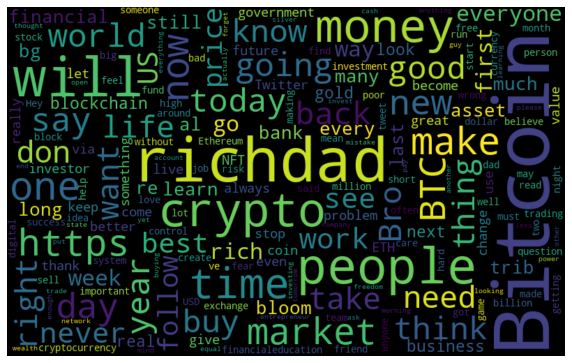

In [175]:
word_cloud_tweets(df_tweets_increase, 'Data_processing_3')

### Top 10

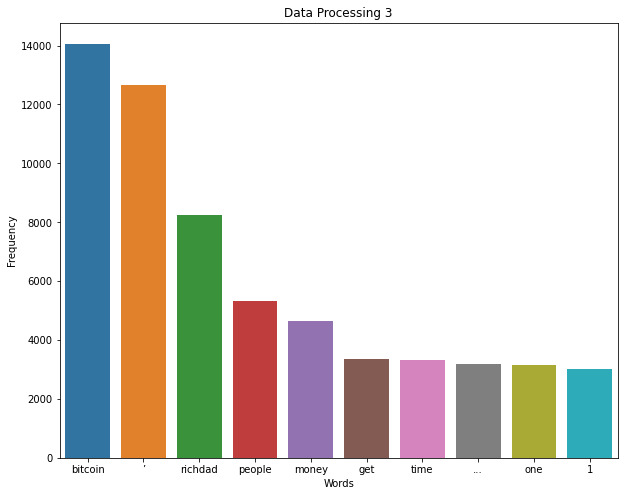

In [176]:
top_most_frequent(df_tweets_increase, 'Data_processing_3', 10, 'Data Processing 3')

### Classification

In [177]:
classify_texts_bag_of_words_log_reg(df_tweets_increase, 'Data_processing_3', 'Raise', 'DP3 - LogReg' )

The accuracy score of the model ->DP3 - LogReg<- is 54.090%


(0.5409033480732786, None)

## Data processing 4
The accuracy score of the model ->DP4 - LogReg<- is 53.822%

In [178]:
stemmer = nltk.PorterStemmer()

In [179]:
processed_phrase = list()

for tweet in df_tweets_increase['Data_processing_3']:
  new_phrase = list()
  tweet = tweet.lower()
  words_txt = tokenizer_punctuation.tokenize(tweet)
  for word in words_txt:
    if word not in stopwords_no_unicode:
      new_phrase.append(stemmer.stem(word))
  processed_phrase.append(' '.join(new_phrase))
df_tweets_increase['Data_processing_4'] = processed_phrase

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


### Word Cloud

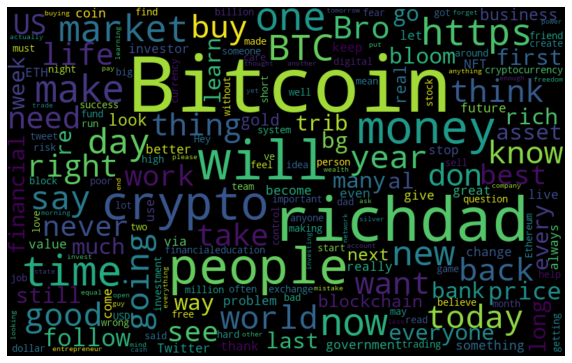

In [180]:
word_cloud_tweets(df_tweets_increase, 'Data_processing_4')

### Top 10

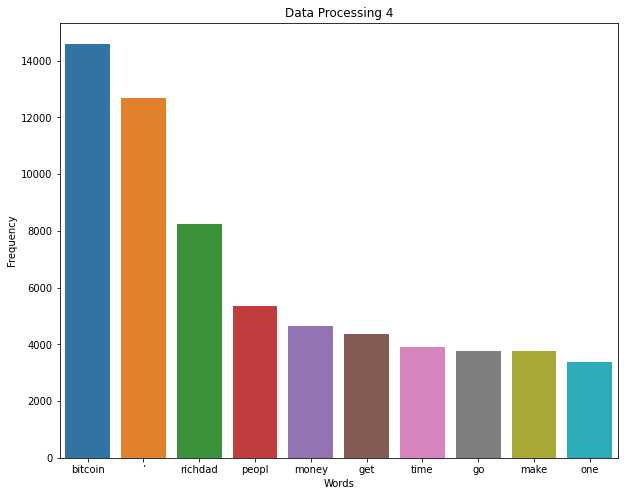

In [181]:
top_most_frequent(df_tweets_increase, 'Data_processing_4', 10, 'Data Processing 4')

### Classification

In [182]:
classify_texts_bag_of_words_log_reg(df_tweets_increase, 'Data_processing_4', 'Raise', 'DP4 - LogReg' )

The accuracy score of the model ->DP4 - LogReg<- is 53.822%


(0.5382185723310171, None)

## Data processing 5
The accuracy score of the model ->DP5 - LogReg<- is 54.027%

In [183]:
sno = nltk.stem.SnowballStemmer('english')

In [184]:
processed_phrase = list()

for tweet in df_tweets_increase['Tweet']:
  new_phrase = list()
  tweet = tweet.lower()
  words_txt = tokenizer_punctuation.tokenize(tweet)
  for word in words_txt:
    if word not in stopwords_no_unicode:
      new_phrase.append(sno.stem(word))
  processed_phrase.append(' '.join(new_phrase))
df_tweets_increase['Data_processing_5'] = processed_phrase

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


### Word Cloud

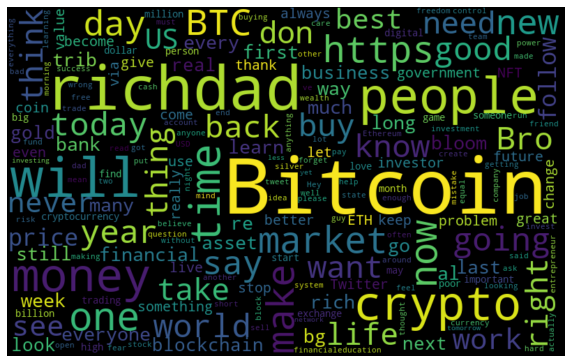

In [185]:
word_cloud_tweets(df_tweets_increase, 'Data_processing_5')

### Top 10

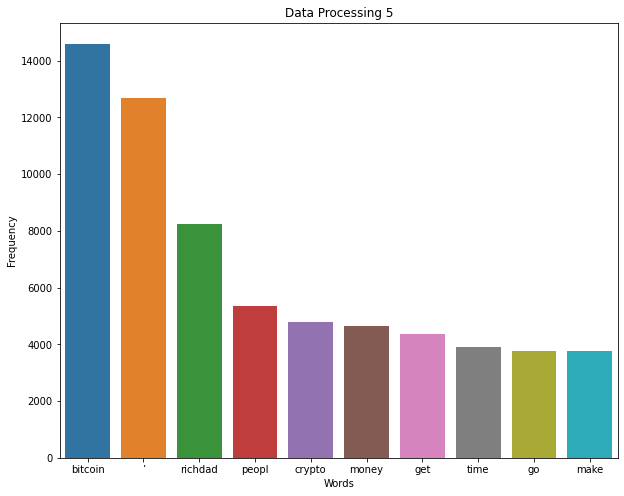

In [186]:
top_most_frequent(df_tweets_increase, 'Data_processing_5', 10, 'Data Processing 5')

### Classification

In [187]:
classify_texts_bag_of_words_log_reg(df_tweets_increase, 'Data_processing_5', 'Raise', 'DP5 - LogReg' )

The accuracy score of the model ->DP5 - LogReg<- is 54.027%


(0.5402716361339229, None)

# Development of Sentiment Analysis

## Dataset: df_tweets_increase

### Function to help the development of the classification model

### LogisticRegression

In [188]:
def classify_texts_tfidf(dataset, text_column, label_column, model_name):
  # Bag of words vectorizer
  tfidf_vectorizer = TfidfTransformer()
  tfdif = TfidfVectorizer(lowercase=False, max_features=50)
  raw_tfidf = tfdif.fit_transform(dataset[text_column])

  # Model
  x_train, x_test, y_label_train, y_label_test = train_test_split(
      raw_tfidf, # X
      dataset[label_column], # Y
      random_state = 42 
      )
  
  # Logistical Regression - Training
  logistical_regression = LogisticRegression(solver='lbfgs')
  logistical_regression.fit(x_train, y_label_train)

  # Logistical Regression - Accuracy Score
  acry_score = logistical_regression.score(x_test, y_label_test)

  return acry_score,  print("The accuracy score of the model {}".format(model_name) + " is {:.3f}".format((acry_score)*100) + "%")



### MultinomialNB

In [189]:
def classify_texts_bag_of_words_crosvalidate(dataset, text_column, label_column, model_name):
  # Bag of words vectorizer
  bw_vectorizer = CountVectorizer(lowercase=False, max_features=50)
  bag_of_words = bw_vectorizer.fit_transform(dataset[text_column])

  # Model
  x_train, x_test, y_label_train, y_label_test = train_test_split(
      bag_of_words, # X
      dataset[label_column], # Y
      random_state = 42 
      )
    
  model = MultinomialNB()
  
  # LMultinomialNB - Training
  model.fit(x_train, y_label_train)
  predictions = model.predict(x_test)


  # LMultinomialNB - Accuracy Score
  acry_score =  accuracy_score(y_label_test, predictions) * 100

  return acry_score,  print("The accuracy score of the model {}".format(model_name) + " is {:.3f}".format((acry_score)) + "%")

### Classification model pipeline with tfidf - LogisticRegression

#### Classification model with not processed data

In [190]:
model_accuracy, accuracy_txt = classify_texts_tfidf(df_tweets_increase, 'Tweet', 'Raise', 'RAW MODEL')
accuracy_txt

The accuracy score of the model RAW MODEL is 54.100%


#### Classification model with first processed data

In [191]:
model_accuracy, accuracy_txt = classify_texts_tfidf(df_tweets_increase, 'Data_processing_1', 'Raise', 'DATA PROCESSING 1')
accuracy_txt

The accuracy score of the model DATA PROCESSING 1 is 53.613%


#### Classification model with second processed data

In [192]:
model_accuracy, accuracy_txt = classify_texts_tfidf(df_tweets_increase, 'Data_processing_2', 'Raise', 'DATA PROCESSING 2')
accuracy_txt

The accuracy score of the model DATA PROCESSING 2 is 53.569%


#### Classification model with tird processed data

In [193]:
model_accuracy, accuracy_txt = classify_texts_tfidf(df_tweets_increase, 'Data_processing_3', 'Raise', 'DATA PROCESSING 3')
accuracy_txt

The accuracy score of the model DATA PROCESSING 3 is 53.980%


#### Classification model with fourth processed data 

In [194]:
model_accuracy, accuracy_txt = classify_texts_tfidf(df_tweets_increase, 'Data_processing_4', 'Raise', 'DATA PROCESSING 4')
accuracy_txt

The accuracy score of the model DATA PROCESSING 4 is 53.841%


#### Classification model with fifth processed data

In [195]:
model_accuracy, accuracy_txt = classify_texts_tfidf(df_tweets_increase, 'Data_processing_5', 'Raise', 'DATA PROCESSING 5')
accuracy_txt

The accuracy score of the model DATA PROCESSING 5 is 53.986%


### Classification model with bag of words - Cross Validation

In [196]:
model_accuracy, accuracy_txt = classify_texts_bag_of_words_crosvalidate(df_tweets_increase, 'Data_processing_5', 'Raise', 'DATA PROCESSING 6')
accuracy_txt

The accuracy score of the model DATA PROCESSING 6 is 53.948%


# Export Dataset

In [197]:
df_tweets_increase

,Tweet,Date,Raise,Data_processing_1,Data_processing_2,Data_processing_3,Data_processing_4,Data_processing_5
0,Reasons why I'm bullish on #Bitcoin:\n\n About...,2021-10-18,1,reasons i'm bullish #bitcoin: retake ath bitco...,reasons i m bullish bitcoin retake ath bitcoin...,reasons bullish bitcoin retake ath bitcoin etf...,reason bullish bitcoin retak ath bitcoin etf a...,reason bullish bitcoin retak ath bitcoin etf a...
1,First U.S. #bitcoin ETF looks set to debut Tue...,2021-10-18,1,first u.s. #bitcoin etf looks set debut tuesda...,first u s bitcoin etf looks set debut tuesday ...,first u bitcoin etf looks set debut tuesday pr...,first u bitcoin etf look set debut tuesday pro...,first u bitcoin etf look set debut tuesday pro...
2,Top10 Twitter KOL & Gem Rating Oct.18\n1 $DOGE...,2021-10-18,1,top10 twitter kol & gem rating oct.18 1 $doge ...,top10 twitter kol gem rating oct 18 1 doge 2 x...,top10 twitter kol gem rating oct 18 1 doge 2 x...,top10 twitter kol gem rate oct 18 1 doge 2 xrp...,top10 twitter kol gem rate oct 18 1 doge david...
3,"#bitcoin over $62,000 again. \n\n$3,000 to go.",2021-10-18,1,"#bitcoin $62,000 again. $3,000 go.",bitcoin 62 000 again 3 000 go,bitcoin 62 000 3 000 go,bitcoin 62 000 3 000 go,bitcoin 62 000 3 000 go
4,Shiba Inu could Reach 50 Cents By December 202...,2021-10-18,1,shiba inu could reach 50 cents december 2022? ...,shiba inu could reach 50 cents december 2022 h...,shiba inu could reach 50 cents december 2022 m...,shiba inu could reach 50 cent decemb 2022 math...,shiba inu could reach 50 cent decemb 2022 math...
...,...,...,...,...,...,...,...,...
63313,"""\n@IconicExpert\n: @nomaxpi \n@CryptoCobain\n...",2014-09-17,0,""" @iconicexpert : @nomaxpi @cryptocobain im wo...",iconicexpert nomaxpi cryptocobain im worth tim...,iconicexpert nomaxpi cryptocobain im worth tim...,iconicexpert nomaxpi cryptocobain im worth tim...,iconicexpert nomaxpi cryptocobain im worth tim...
63314,Can someone send me their btc address? Theblon...,2014-09-17,0,someone send btc address? theblonde offered bi...,someone send btc address theblonde offered bit...,someone send btc address theblonde offered bit...,someon send btc address theblond offer bitcoin...,someon send btc address theblond offer bitcoin...
63315,"""\n@moolah_io\n: @GambitBTC $VIA is on the fin...",2014-09-17,0,""" @moolah_io : @gambitbtc $via final list. ple...",moolah_io gambitbtc via final list please chec...,moolah_io gambitbtc via final list please chec...,moolah_io gambitbtc via final list pleas check...,moolah_io gambitbtc via final list pleas check...
63316,What if we all take out loans + buy bitcoin. D...,2014-09-17,0,take loans + buy bitcoin. default loans. cause...,take loans buy bitcoin default loans cause len...,take loans buy bitcoin default loans cause len...,take loan buy bitcoin default loan caus lend c...,take loan buy bitcoin default loan caus lend c...


In [198]:
df_tweets_increase.to_csv("/content/drive/MyDrive/DI - Analise Bitcoin - GPU/4. Execução/2. Analise de Sentimento/tweets_increase_nlp.csv")